KeyboardInterrupt: 

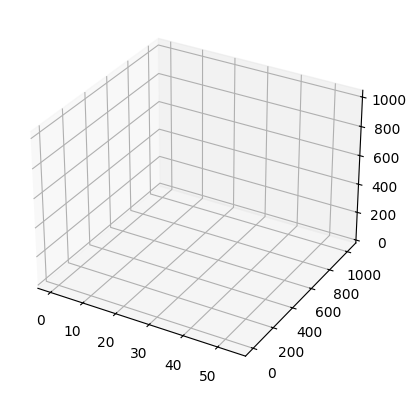

In [14]:
#testing img processing

import tifffile
import numpy as np
from skimage import filters, exposure

# Path to your OME-TIFF file
file_path = '/Users/presentation/converttest.ome.tiff'

# Read the OME-TIFF file
with tifffile.TiffFile(file_path) as tif:
    images = tif.asarray()  # Load the image stack into a numpy array

# Now, images is a numpy array with dimensions (Z, C, Y, X), where:
# Z = Number of slices in the stack
# C = Number of channels (e.g., DAPI, 594, 647)
# Y = Pixel height of the images
# X = Pixel width of the images

# You can process each channel separately. For example:
# Apply a filter, normalize or any other process you need

# Let's say we want to apply a Gaussian filter to the DAPI channel (assuming it's the first channel)
dapi_channel = images[:, 0, :, :]  # Assuming the first channel is DAPI
dapi_blurred = filters.gaussian(dapi_channel, sigma=1)

# Or you might want to equalize the histogram of another channel
channel_594 = images[:, 1, :, :]  # Assuming the second channel is 594
channel_594_eq = exposure.equalize_hist(channel_594)

# You would perform similar operations for the 647 channel

# If you need to do 3D visualization, you might use `matplotlib` or `mayavi` for that purpose:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# You might have to process your data (e.g., thresholding) to get binary data suitable for 3D visualization

# This is just an example and won't work out-of-the-box for volume rendering.
# Actual 3D visualization would require proper data processing to be meaningful.
ax.voxels(dapi_blurred, edgecolor='k')

plt.show()


### java dependencies need sorting before being able to deploy javabridge

## skeleton notebook

In [ ]:
import os
import javabridge
import bioformats
import numpy as np
from tifffile import imsave

def lif_to_tiff(input_path, output_dir, ome_tiff=False):
    # Start the Java Virtual Machine
    javabridge.start_vm(class_path=bioformats.JARS)

    # Read the .lif file with bioformats
    r = bioformats.ImageReader(input_path)
    
    # Determine number of series (individual images) in the .lif file
    n_series = r.rdr.getSeriesCount()

    for series in range(n_series):
        r.rdr.setSeries(series)
        
        # Get image dimensions
        x, y, z, c, t = (r.rdr.getSizeX(), r.rdr.getSizeY(), r.rdr.getSizeZ(), 
                         r.rdr.getSizeC(), r.rdr.getSizeT())

        # Initialize an empty array for image data
        img_data = np.empty((t, z, y, x, c), dtype=np.uint16)

        # Fill the array with image data
        for ti in range(t):
            for zi in range(z):
                for ci in range(c):
                    img_data[ti, zi, :, :, ci] = r.read(z=zi, t=ti, c=ci, rescale=False)

        # Save as TIFF or OME-TIFF
        filename = f"image_series_{series}"
        filepath = os.path.join(output_dir, filename + ('.ome.tiff' if ome_tiff else '.tiff'))
        imsave(filepath, img_data)

    # Close the Java Virtual Machine
    javabridge.kill_vm()

if __name__ == "__main__":
    input_lif = "path_to_your_file.lif"
    output_directory = "path_for_output_files"
    lif_to_tiff(input_lif, output_directory, ome_tiff=True)


In [3]:
##concepts: NOT EXECUTABLE

import numpy as np
import javabridge
import bioformats

from skimage import morphology, measure, filters
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Initialize Java Virtual Machine
javabridge.start_vm(class_path=bioformats.JARS)

def load_ome_tiff(file_path):
    # Read OME-TIFF using bioformats
    img, meta = bioformats.read_image(file_path, rescale=False, wants_max_intensity=True, return_metadata=True)
    return img, meta

def preprocess(data):
    # Preprocessing steps, e.g., normalization
    return (data - data.min()) / (data.max() - data.min())

def segment(data):
    # Segmentation using a simple threshold (this can be replaced with more complex methods)
    threshold = filters.threshold_otsu(data)
    return data > threshold

def morphological_analysis(data):
    convex_hull = morphology.convex_hull_image(data)
    complexity = measure.perimeter(data) / np.sqrt(4 * np.pi * measure.area(data))
    return convex_hull, complexity

def extract_features(data):
    # Feature extraction for ML
    features = {
        'mean_intensity': np.mean(data),
        'standard_deviation': np.std(data)
    }
    return features

def ml_model(features, labels):
    # Train a simple random forest classifier for this example
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    return accuracy

# Main execution
file_path = "path_to_your_ome.tiff"
image, metadata = load_ome_tiff(file_path)
processed_image = preprocess(image)
binary_image = segment(processed_image)
convex, complexity = morphological_analysis(binary_image)

# Extract features from each image for ML (you'd loop over many images here)
features = []
labels = []  # You would also need a label for each image
features.append(extract_features(binary_image))

# Train ML model
accuracy = ml_model(features, labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Shutdown JVM
javabridge.kill_vm()


ModuleNotFoundError: No module named 'javabridge'

In [ ]:
## READ TIFF STACK

from tifffile import imread
stack = imread('path_to_your_stack.tif')


In [ ]:

from skimage.filters import gaussian
smoothed = gaussian(stack, sigma=1)


In [ ]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(smoothed)
binary = smoothed > thresh

# ALTERNATIVES TO THRESHOLDING
While thresholding is a basic technique, many advanced alternatives can yield better segmentation results, especially in challenging datasets with variability in intensity, noise, and other artifacts. Some of the more advanced alternatives to threshold-based segmentation include:

1. **Active Contours (Snake Algorithms)**:
    - Active contours aim to find an optimal curve (in 2D) or surface (in 3D) separating the object from the background.
    - The initial contour is iteratively evolved by considering image-based forces (like gradients) and internal constraints (like smoothness or elasticity).

2. **Watershed Segmentation**:
    - This method treats image intensity as a topographic landscape with hills and valleys.
    - "Floodwaters" are poured onto this landscape from predefined markers, and "basins" are filled up, resulting in segmented regions.

3. **Random Forests and Machine Learning**:
    - This approach involves training a classifier (like Random Forest) using handpicked features from labeled examples of the regions of interest and background.
    - Once the classifier is trained, it can be used to predict the class (object or background) of every pixel or voxel in the image.

4. **Deep Learning and Convolutional Neural Networks (CNNs)**:
    - Deep learning, especially CNNs, has achieved state-of-the-art performance in many segmentation tasks.
    - U-Net is a popular CNN architecture designed for biomedical image segmentation. It requires labeled training data.
    - Transfer learning, where a pre-trained model is fine-tuned on a smaller dataset, can be useful if you don't have a large annotated dataset.

5. **Level Set Methods**:
    - Level set methods represent a curve (in 2D) or a surface (in 3D) as the zero level of a higher-dimensional function.
    - This implicit representation is evolved over time according to predefined criteria, allowing for topological changes and providing a flexible framework for segmentation.

6. **Graph-based Segmentation**:
    - In this method, an image is represented as a graph, where pixels/voxels are nodes and edges are defined based on pixel/voxel relationships.
    - Graph cuts or minimum cut methods can be used to find the optimal segmentation.

7. **Region Growing**:
    - Starting from a seed point, pixels or voxels are iteratively added to the region based on predefined criteria, such as intensity similarity.

8. **Atlas-guided and Model-based Methods**:
    - For structured images (like MRIs of the brain), predefined models or atlases can guide the segmentation.
    - These methods aim to match or register the model to the observed data, benefiting from prior knowledge about the structure of interest.

When choosing an advanced method, it's essential to consider the nature of your data, the availability of labeled training data (for supervised methods), computational resources, and the specific challenges your images present (e.g., low contrast, overlapping objects). Often, combining multiple methods (ensemble methods or hybrid approaches) or post-processing steps can improve results further.

In [ ]:

from skimage.morphology import opening, closing, disk
refined = opening(binary, disk(3))


In [ ]:
from skimage.morphology import skeletonize_3d
skeleton = skeletonize_3d(refined)


In [ ]:
from skimage.measure import label, regionprops

labeled = label(refined)
properties = regionprops(labeled)

for prop in properties:
    volume = prop.area
    eccentricity = prop.eccentricity
    

    
    # ... and other measurements


In [ ]:
import napari

viewer = napari.Viewer()
viewer.add_image(your_confocal_data)
